# DL-Tabular

For this purpose, we will use the heart disease UCI data

In [ ]:
# https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89
# https://towardsdatascience.com/pytorch-basics-intro-to-dataloaders-and-loss-functions-868e86450047

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import shap


In [2]:
data = pd.read_csv("C:/Users/joaof/Downloads/processed.cleveland.data",header=None)

In [3]:
headers=["age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num"]
data.columns=headers

In [4]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


Since we want to create a simple classification problem, we will transform the variable num into a dual category, presence (1,2,3,4) or absence disease (0)

In [5]:
data['target'] = data['num'].apply(lambda x: 1 if x>=1 else 0)

In [6]:
data.drop(columns=['num'],inplace=True)

In [7]:
data.describe(include="all")

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303,303,303.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,4,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,176,166,NaN
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,NaN,NaN,0.458746
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,NaN,NaN,0.499120
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,NaN,NaN,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,NaN,NaN,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,NaN,NaN,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,NaN,NaN,1.000000


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB


<AxesSubplot:xlabel='target', ylabel='count'>

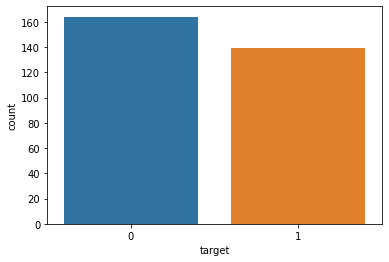

In [9]:
sns.countplot(x = 'target', data=data)

<AxesSubplot:xlabel='ca', ylabel='count'>

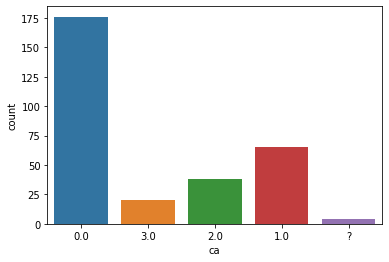

In [10]:
sns.countplot(x = 'ca', data=data)

<AxesSubplot:xlabel='thal', ylabel='count'>

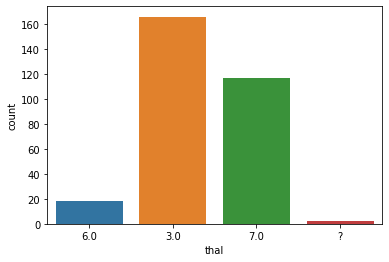

In [11]:
sns.countplot(x = 'thal', data=data)

since they are so low, lets remove the "?"

In [12]:
data.drop(data[data["thal"]=="?"].index,inplace=True)
data.drop(data[data["ca"]=="?"].index,inplace=True)
data.reset_index(inplace=True,drop=True)

In [13]:
y=data.iloc[:,-1]
X=data.iloc[:,0:-1]

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2,random_state=42)

<AxesSubplot:xlabel='target', ylabel='count'>

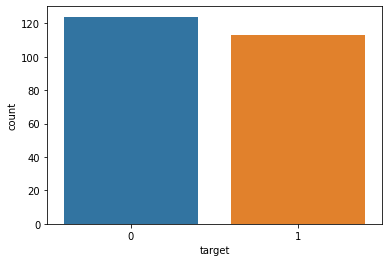

In [15]:
sns.countplot(x = y_train)

<AxesSubplot:xlabel='target', ylabel='count'>

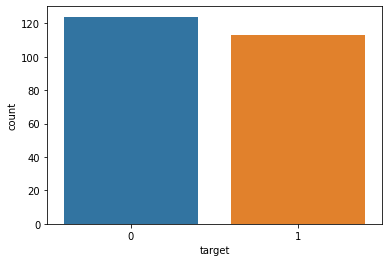

In [16]:
sns.countplot(x = y_train)

In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [18]:
len(X_train[0])

13

In [19]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [20]:
#dataloader
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

In [21]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [22]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(13, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [24]:
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=13, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [25]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [26]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.66493 | Acc: 59.750
Epoch 002: | Loss: 0.55656 | Acc: 73.750
Epoch 003: | Loss: 0.48285 | Acc: 78.000
Epoch 004: | Loss: 0.43004 | Acc: 82.000
Epoch 005: | Loss: 0.40288 | Acc: 83.250
Epoch 006: | Loss: 0.37856 | Acc: 83.000
Epoch 007: | Loss: 0.37447 | Acc: 81.750
Epoch 008: | Loss: 0.35796 | Acc: 85.000
Epoch 009: | Loss: 0.33799 | Acc: 86.000
Epoch 010: | Loss: 0.32134 | Acc: 86.500
Epoch 011: | Loss: 0.30912 | Acc: 87.000
Epoch 012: | Loss: 0.31081 | Acc: 87.250
Epoch 013: | Loss: 0.31029 | Acc: 87.000
Epoch 014: | Loss: 0.27535 | Acc: 88.500
Epoch 015: | Loss: 0.28111 | Acc: 87.000
Epoch 016: | Loss: 0.26356 | Acc: 88.750
Epoch 017: | Loss: 0.25026 | Acc: 91.500
Epoch 018: | Loss: 0.25809 | Acc: 90.000
Epoch 019: | Loss: 0.22388 | Acc: 92.250
Epoch 020: | Loss: 0.20497 | Acc: 94.250
Epoch 021: | Loss: 0.21943 | Acc: 93.250
Epoch 022: | Loss: 0.21086 | Acc: 92.250
Epoch 023: | Loss: 0.19821 | Acc: 94.000
Epoch 024: | Loss: 0.18368 | Acc: 96.000
Epoch 025: | Los